In [1]:
# global settings
import random
import numpy as np
import os

N_CPU = 12 # number of CPUs for parallel operations
random_state = 42

# logging settings
from qsprpred.logs.utils import enable_file_logger, export_conda_environment
logSettings = enable_file_logger(
    log_folder = 'qspr/models',
    filename = 'Modelling.log',
    debug = False,
    disable_existing_loggers = False
)

# save the environment to a yaml file
export_conda_environment("qspr/models/environment.yml")


Environment exported to qspr/models/environment.yml successfully!


In [2]:
# Already run this tutorial before? You can reload your data/models by running this cell and uncommenting the models/data you need.
from qsprpred.data.data import QSPRDataset
from qsprpred.models.interfaces import QSPRModel

# For the regression part of the tutorial
#dataset = QSPRDataset.fromFile('./qspr/data/tutorial_data_df.pkl')
# model = QSPRModel.fromFile('./qspr/models/PLS_REG/PLS_REG_meta.json')

# For the classification part of the tutorial
#dataset = QSPRDataset.fromFile('./qspr/data/A2A_LIGANDS_df.pkl')
# fitted_models = [QSPRModel.fromFile('./qspr/models/ExtraTreesClassifier/ExtraTreesClassifier_meta.json'),
#                  QSPRModel.fromFile('./qspr/models/RandomForestClassifier/RandomForestClassifier_meta.json')]

## Data Sets

QSPRPred package defines the `QSPRDataset` class, which is used to manage data and supply it to the models of interest (see [data_preparation](./data_preparation.ipynb) and [data_preparation_advanced](./data_preparation_advanced.ipynb)). We already assume you are familiar with these data structures, and we will use example data sets that are loaded automatically via the `datasets.py` module defined in the current folder. Feel free to examine this code to see how the data is loaded and preprocessed.

## Building Models - Regression

Here, we will show how to train a simple single task regression model with QSPRPred.

### Preparing the Data

We will load the `Parkinsons` data set from `datasets.py`:

In [9]:
from datasets import Parkinsons

dataset = Parkinsons(random_state=random_state)
dataset.getDF()

Number of samples per target:
accession
GABAAalpha    6280
NMDA          4073
P41594        2730
Q14416        1342
Q13255         975
Q14833         856
Q14832         172
O00222         153
O15303         104
Q14831          89
Q14643          12
Name: count, dtype: int64


accession,SMILES,GABAAalpha,NMDA,O00222,O15303,P41594,Q13255,Q14416,Q14643,Q14831,Q14832,Q14833,QSPRID
QSPRID,,,,,,,,,,,,,
tutorial_data_1,Brc1ccc2c(c1)-c1ncnn1Cc1c(-c3cccs3)ncn-21,8.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_data_1
tutorial_data_2,Brc1ccc2c(c1)-c1nncn1Cc1c(I)ncn-21,8.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_data_2
tutorial_data_3,Brc1cccc(-c2cc(-c3ccccc3)nnc2)c1,8.013333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_data_3
tutorial_data_4,Brc1cccc(-c2cnnc(NCc3ccccc3)c2)c1,7.505000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_data_4
tutorial_data_5,Brc1cccc(-c2cnnc(OCc3ccccc3)c2)c1,6.860000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_data_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
tutorial_data_8206,c1cnc(COc2nn3c(C4CC4)nnc3c3c2C2CCC3CC2)cc1,7.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_data_8206
tutorial_data_8207,c1cnc(COc2nn3c(C4CC4)nnc3c3c2cccc3)cc1,8.440000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_data_8207
tutorial_data_8208,c1cnc(COc2nn3c(C4CCC4)nnc3c3c2cccc3)cc1,7.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tutorial_data_8208


We will build a regression model for the GABA(A) receptor subunit alpha (GABAAalpha).
Therefore, we initialize our QSPRdataset as regression for "GABAAalpha".
After this we need to do some processing of the data.
We need to calculate compound features, split our dataset into a train and test set.

In [10]:
from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.descriptorcalculator import MoleculeDescriptorsCalculator
from sklearn.preprocessing import StandardScaler as Scaler
from qsprpred.data.utils.datasplitters import RandomSplit

# Calculate MorganFP and physicochemical properties
feature_calculator = MoleculeDescriptorsCalculator(desc_sets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)])

# Do a random split for creating the train (85%) and test set (15%)
rand_split = RandomSplit(test_fraction=0.2, dataset=dataset)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=rand_split,
    feature_calculators=[feature_calculator],
    feature_standardizer=Scaler()
)

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}")

Missing values filled with nan


Number of samples train set: 1640
Number of samples test set: 410


The `prepareDataset` function is shorthand method that can be used to perform multiple steps at once, but these steps can also be performed individually. For example, we can calculate the features and split the dataset separately by several calls to various methods of the `QSPRDataset` class. The following code should be equivalent to the previous one:

```python

# Calculate MorganFP and physicochemical properties
feature_calculator = MoleculeDescriptorsCalculator(desc_sets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)])
dataset.addDescriptors(feature_calculator, featurize=False)
dataset.fillMissingValues()
dataset.splitDataset(rand_split)
dataset.setFeatureStandardizer(Scaler())
self.featurizeSplits()
```

In [11]:
# Let's save the dataset for later
dataset.save()

### Training the Model

After preparing our dataset, we will train a QSPR regression model.
In this tutorial we will train a XGBoost model as it generally performs well, but there are other model types
available. Most machine learning models have tunable hyperparameters (for example depth & learning rate), as some hyperparameter combinations will lead to better performance on a task we perform hyperparameter optimization (in which different combinations are tested and evaluated on a subset of the training data). After finding good hyperparameters a model will be trained on the training data & evaluated on the test data. In addition to this the final model will be trained on all data

In [15]:
from qsprpred.models.sklearn import SklearnModel
from sklearn.cross_decomposition import PLSRegression
from qsprpred.models.hyperparam_optimization import OptunaOptimization
from qsprpred.models.assessment_methods import CrossValAssessor, TestSetAssessor
from qsprpred.models.metrics import SklearnMetric

# This is an SKlearn model, so we will initialize it with the SklearnModel class
model = SklearnModel(base_dir = 'qspr/models/', data=dataset, alg = PLSRegression, name='PLS_REG')

# We will first optimize the hyperparameters (n_components and scale) through bayes optimization
# the best hyperparameter combination will be saved in PLS_REG_GABAAalpha_params.json
score_func = SklearnMetric.getDefaultMetric(model.task)
search_space_bs = {"n_components": ["int", 1, 30], "scale": ["categorical", [True, False]]}
bayesoptimizer = OptunaOptimization(param_grid=search_space_bs, n_trials=5, n_jobs=4,
                                    model_assessor=CrossValAssessor(scoring=score_func))
best_params = bayesoptimizer.optimize(model)

#Then we will evaluate the performance of the best model using the independent test set
CrossValAssessor(scoring=score_func)(model)
TestSetAssessor(scoring=score_func)(model)

# Finally, we need to fit the model on the complete dataset if we want to use it further
# model is saved under qsprmodels/PLS_REG_GABAAalpha.pkg
model.fitAttached(scoring=score_func)

At the moment n_jobs>1 not available for bayes optimization, n_jobs set to 1.
[I 2023-10-27 16:59:24,692] A new study created in memory with name: no-name-c76adf4a-f11e-48d7-9f0f-2aa8635e2a50
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
[I 2023-10-27 16:59:26,336] Trial 0 finished with value: 0.5476851216058265 and parameters: {'n_components': 12, 'scale': True}. Best is trial 0 with value: 0.5476851216058265.
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different leng

'qspr/models/PLS_REG/PLS_REG_meta.json'

## Evaluating the results

In [16]:
# we need to sve the model first
model.save()

'qspr/models/PLS_REG/PLS_REG_meta.json'

Plotting the results of our model on the test set we can see that it is performing reasonably well.

<Axes: title={'center': 'PLS_REG (PLSRegression)'}, xlabel='Experimental GABAAalpha', ylabel='Predicted GABAAalpha'>

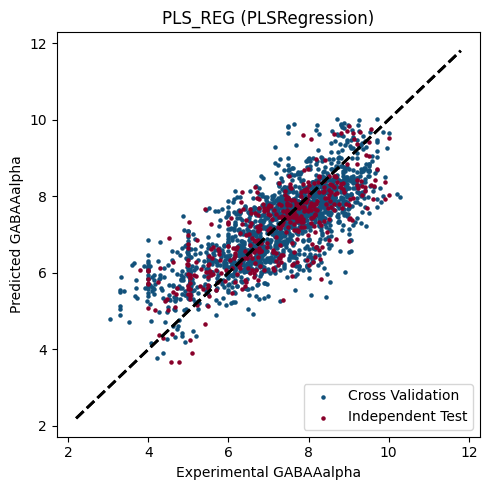

In [17]:
from qsprpred.plotting.regression import CorrelationPlot
from qsprpred.models.interfaces import QSPRModel

# give path to saved metadata of the model and load it
#metadata_path = './qspr/models/PLS_GABAAalpha_REGRESSION/PLS_GABAAalpha_REGRESSION_meta.json'
#model = QSPRModel.fromFile(metadata_path)
model
plt = CorrelationPlot([model])
axes, summary = plt.make(save=False, property_name='GABAAalpha')
axes[0]

As you can see, the plot also generates a summary with the displayed metrics:

In [18]:
summary

,ModelName,R2,RMSE,Set
0,PLS_REG,0.577046,0.885652,cv
1,PLS_REG,0.605061,0.860299,ind


## Building Models - Classification

In this part of the tutorial, we show how to train a simple single task classification model with QSPRPred.

### Preparing the Data

We will repeat the same steps as with the regression model, but this time with classification data loaded from `datasets.py`:

In [5]:
from qsprpred.data.utils.datasplitters import ScaffoldSplit, GBMTRandomSplit, ClusterSplit
from qsprpred.data.utils.descriptorcalculator import MoleculeDescriptorsCalculator
from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.featurefilters import LowVarianceFilter, HighCorrelationFilter
from qsprpred.data.utils.scaffolds import Murcko
from datasets import A2AR

# intialize the dataset
dataset = A2AR(random_state=random_state)

# Calculate MorganFP and physicochemical properties
feature_calculator = MoleculeDescriptorsCalculator(desc_sets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)])

# Split on scaffolds
split = ScaffoldSplit(dataset=dataset, scaffold=Murcko(), test_fraction=0.2)

# Remove features that have a low variance (<0.05) in the trainingset
lv = LowVarianceFilter(0.05)

# Remove features that have a high correlation (>0.9) in the trainingset
hc = HighCorrelationFilter(0.8)

dataset.prepareDataset(
    split=split,
    feature_calculators=[feature_calculator],
    feature_filters=[lv, hc]
)

# save the data set if you do not want to recalculate descriptors
dataset.save()

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}, {len(dataset.y_ind) / len(dataset.df) * 100}%")

########## DISCLAIMER ##########
You are downloading the high-quality Papyrus++ dataset.
Should you want to access the entire, though of lower quality, Papyrus dataset,
look into additional switches of this command.
################################
Number of files to be downloaded: 3
Total size: 33.0MB


Using existing data from data/A2A_LIGANDS.tsv...
Number of samples loaded: 4082


Missing values filled with nan


{}
Number of samples train set: 3266
Number of samples test set: 816, 19.99020088192063%


Let's save the dataset again so that we do not have to recalculate anything later:

In [4]:
dataset.save()

As you can see, the training part basically works the same way as with regression, but to mix things up we build two models at once here:

In [10]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from qsprpred.models.sklearn import SklearnModel
from qsprpred.models.hyperparam_optimization import GridSearchOptimization
from qsprpred.models.assessment_methods import CrossValAssessor, TestSetAssessor
from qsprpred.models.metrics import SklearnMetric
from qsprpred.models.monitors import BaseMonitor

params = {
    'n_estimators' : [50, 200],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    "n_jobs": [1]
}


fitted_models = []
for model in [ExtraTreesClassifier, RandomForestClassifier]:
    model = SklearnModel(
        base_dir='qspr/models/',
        data=dataset, 
        alg = model,
        name=model.__name__,
        random_state=random_state
    )

    monitor = BaseMonitor()
    score_func = SklearnMetric.getDefaultMetric(model.task)
    gridsearcher = GridSearchOptimization(
        model_assessor=CrossValAssessor(scoring = score_func), param_grid=params,
        monitor=monitor
    )
    best_params = gridsearcher.optimize(model)

    CrossValAssessor(scoring = score_func)(model)
    TestSetAssessor(scoring = score_func)(model)
    model.fitAttached()
    
    fitted_models.append(model)

fitted_models

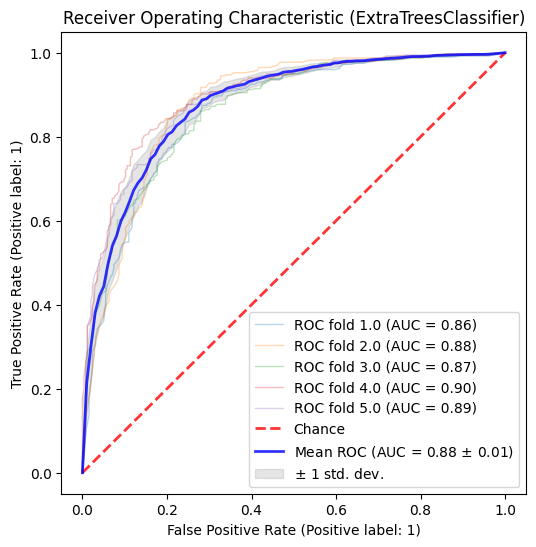

<Figure size 640x480 with 0 Axes>

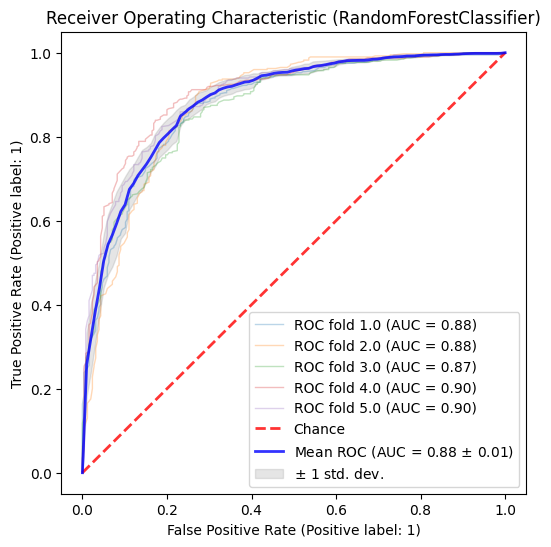

[<Figure size 600x600 with 1 Axes>, <Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [11]:
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot(fitted_models)
plot.make(save=True, show=True, property_name="pchembl_value_Median_class", validation="cv")

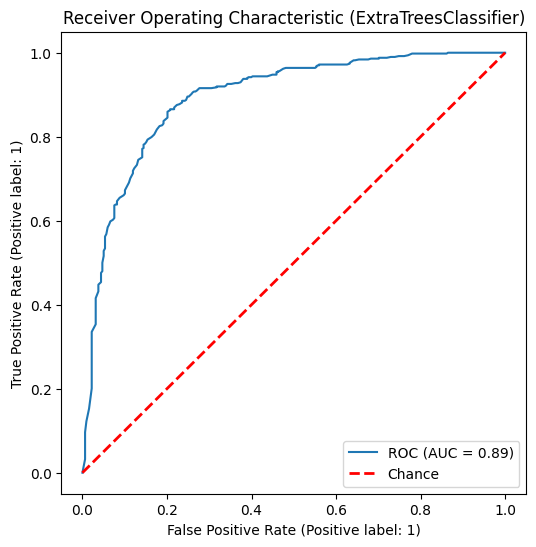

<Figure size 640x480 with 0 Axes>

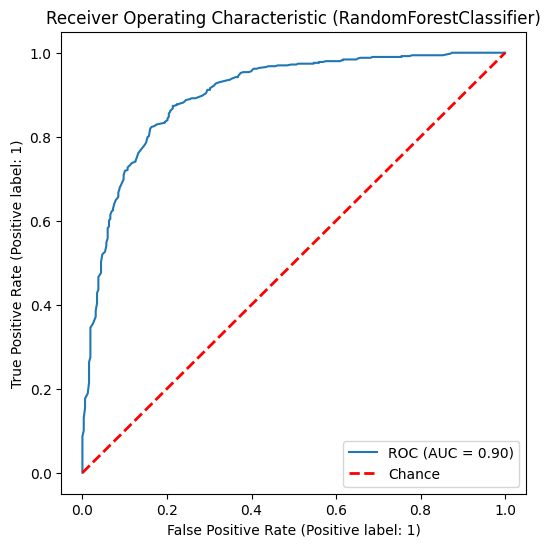

[<Figure size 600x600 with 1 Axes>, <Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [12]:
plot.make(save = True, show=True, property_name="pchembl_value_Median_class", validation="ind")

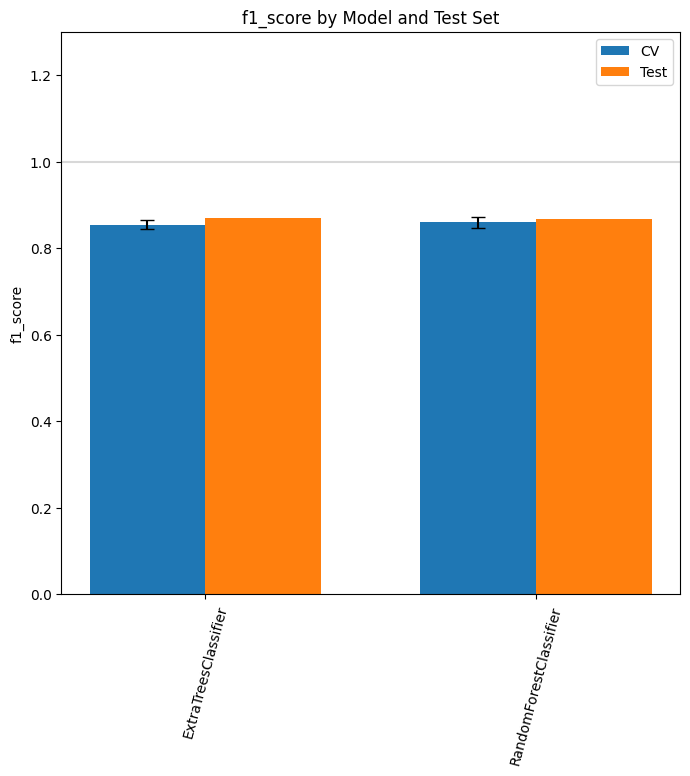

<Figure size 640x480 with 0 Axes>

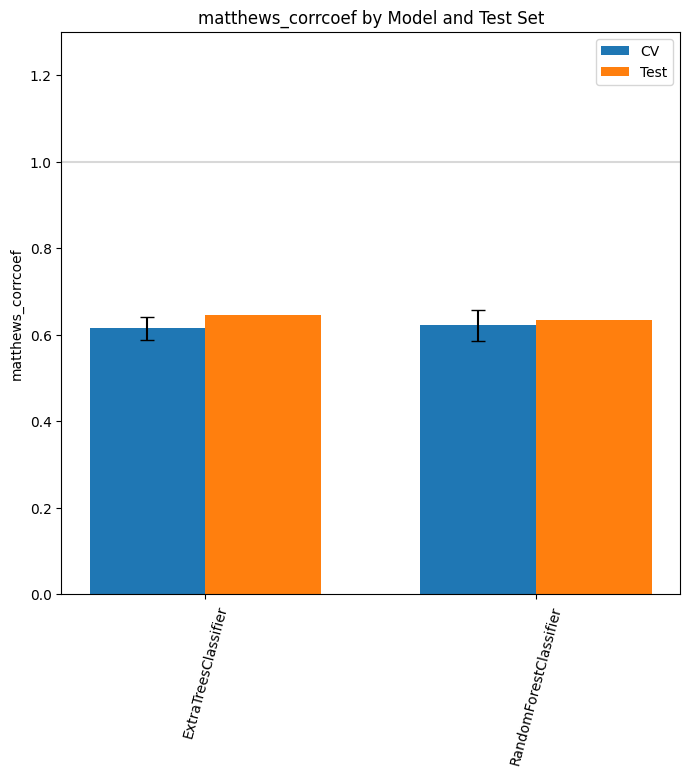

<Figure size 640x480 with 0 Axes>

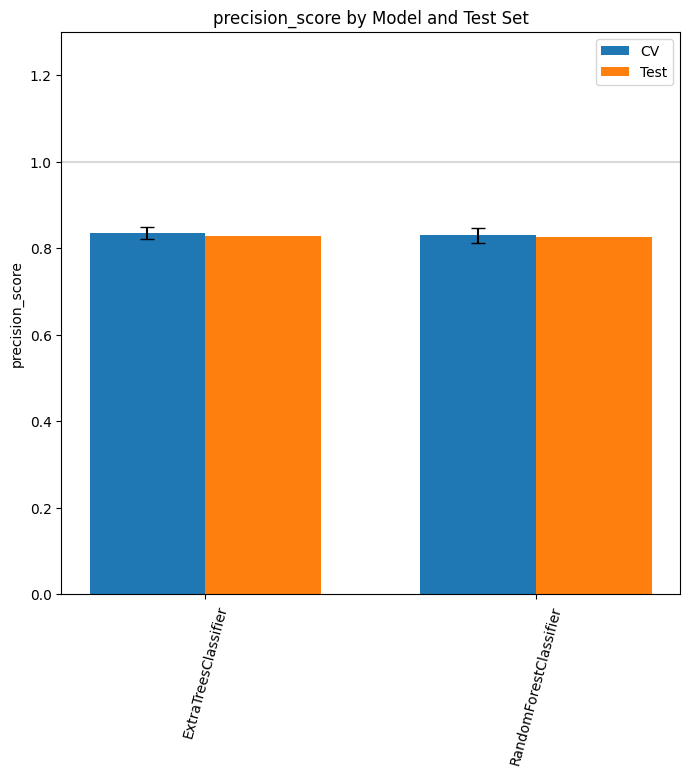

<Figure size 640x480 with 0 Axes>

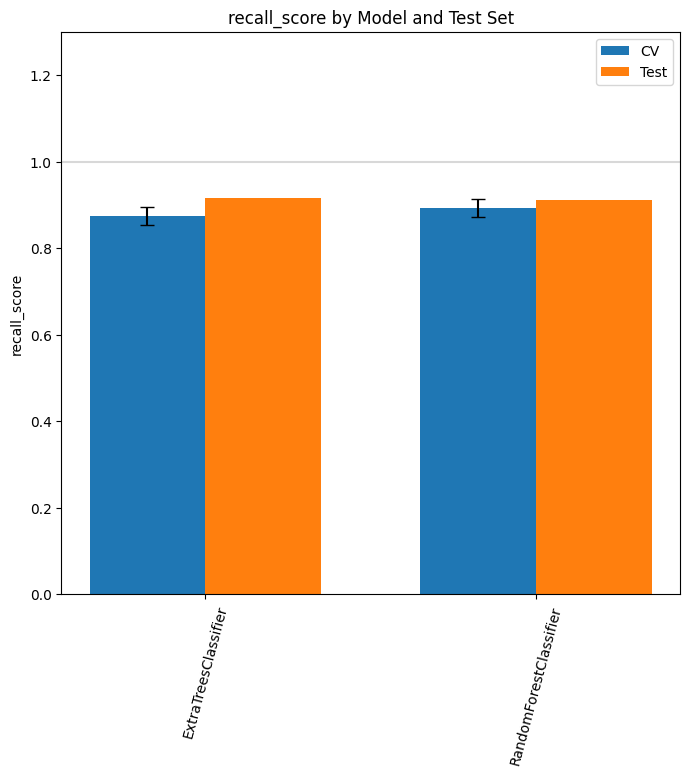

<Figure size 640x480 with 0 Axes>

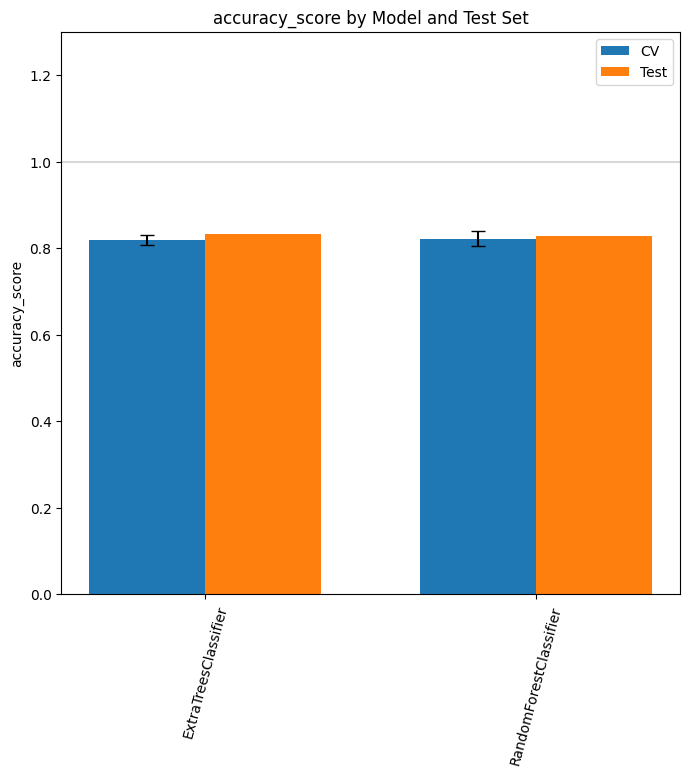

<Figure size 640x480 with 0 Axes>

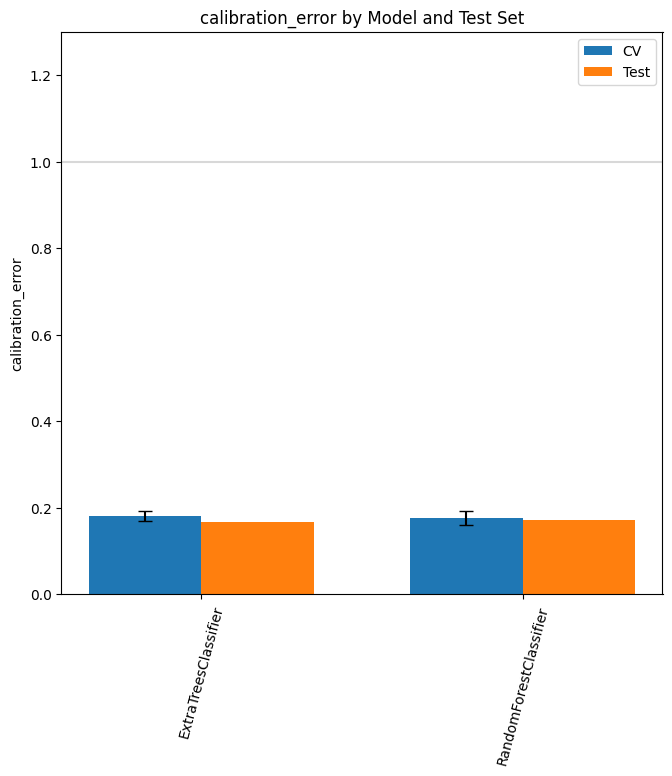

<Figure size 640x480 with 0 Axes>

In [13]:
from qsprpred.plotting.classification import MetricsPlot

plot = MetricsPlot(fitted_models)
figs, summary = plot.make(save=True, show=True, property_name="pchembl_value_Median_class", out_dir="qspr/models/")

Again, the summary contains the data frame with the metrics used to create the plots:

In [14]:
summary

,Metric,Model,TestSet,Value
0,f1_score,ExtraTreesClassifier,CV1.0,0.847001
1,matthews_corrcoef,ExtraTreesClassifier,CV1.0,0.593924
2,precision_score,ExtraTreesClassifier,CV1.0,0.827751
3,recall_score,ExtraTreesClassifier,CV1.0,0.867168
4,accuracy_score,ExtraTreesClassifier,CV1.0,0.808869
...,...,...,...,...
67,matthews_corrcoef,RandomForestClassifier,IND,0.634402
68,precision_score,RandomForestClassifier,IND,0.825455
69,recall_score,RandomForestClassifier,IND,0.911647
70,accuracy_score,RandomForestClassifier,IND,0.828431


## Multitask Regression Model
Until now, the examples have show models that predict one property (single task). In addition to this we can also make multitask models that are trained with multiple different properties simultaneously. This can, for example, be a model that predicts the bioactivity on two or more proteins. Below, we will build a multitask model for 8 different human mGLU receptors.

Data on the mGLU receptors can also be found in the `Parkinsons` dataset. Here we specify that singletask is False, so that all the targets are set as properties to predict (see `datasets.py` for the exact code, note the now necessary imputation step):

In [3]:
from datasets import Parkinsons

dataset = Parkinsons(singletask=False, random_state=random_state)
dataset.targetProperties

[TargetProperty(name=O00222_imputed, task=REGRESSION),
 TargetProperty(name=O15303_imputed, task=REGRESSION),
 TargetProperty(name=P41594_imputed, task=REGRESSION),
 TargetProperty(name=Q13255_imputed, task=REGRESSION),
 TargetProperty(name=Q14416_imputed, task=REGRESSION),
 TargetProperty(name=Q14831_imputed, task=REGRESSION),
 TargetProperty(name=Q14832_imputed, task=REGRESSION),
 TargetProperty(name=Q14833_imputed, task=REGRESSION)]

In [4]:
dataset.getDF()

accession,SMILES,GABAAalpha,NMDA,O00222,O15303,P41594,Q13255,Q14416,Q14643,Q14831,...,Q14833,QSPRID,O00222_imputed,O15303_imputed,P41594_imputed,Q13255_imputed,Q14416_imputed,Q14831_imputed,Q14832_imputed,Q14833_imputed
QSPRID,,,,,,,,,,,,,,,,,,,,,
tutorial_data_0,Brc1cc(-c2nc(-c3ncccc3)no2)ccc1,NaN,NaN,NaN,NaN,6.930,NaN,NaN,NaN,NaN,...,NaN,tutorial_data_0,5.070667,4.955192,6.93000,6.286032,6.824711,4.752146,6.044017,5.833706
tutorial_data_7,Brc1cccc(Sc2ccnc(-c3ccccn3)n2)c1,NaN,NaN,NaN,NaN,5.542,NaN,NaN,NaN,NaN,...,NaN,tutorial_data_7,5.070667,4.955192,5.54200,6.286032,6.824711,4.752146,6.044017,5.833706
tutorial_data_8,Brc1cccc2c1ccc(C#Cc1ccccn1)n2,NaN,NaN,NaN,NaN,6.123,NaN,NaN,NaN,NaN,...,NaN,tutorial_data_8,5.070667,4.955192,6.12300,6.286032,6.824711,4.752146,6.044017,5.833706
tutorial_data_10,C#CC(C)(C)Nc1c2c(ncc1)sc1c2ncn(-c2ccc(C)cc2)c1=O,NaN,NaN,NaN,NaN,NaN,6.770,NaN,NaN,NaN,...,NaN,tutorial_data_10,5.070667,4.955192,6.46138,6.770000,6.824711,4.752146,6.044017,5.833706
tutorial_data_11,C#CC(C)Nc1c2c(ncc1)sc1c2ncn(-c2ccc(C)cc2)c1=O,NaN,NaN,NaN,NaN,NaN,6.502,NaN,NaN,NaN,...,NaN,tutorial_data_11,5.070667,4.955192,6.46138,6.502000,6.824711,4.752146,6.044017,5.833706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tutorial_data_8216,c1cnc(Oc2cccc(-n3nnc(-c4ncccc4)n3)c2)cc1,NaN,NaN,NaN,NaN,5.540,NaN,NaN,NaN,NaN,...,NaN,tutorial_data_8216,5.070667,4.955192,5.54000,6.286032,6.824711,4.752146,6.044017,5.833706
tutorial_data_8218,c1csc(-n2cc(-c3ccnc4ccccc34)cn2)c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.370,tutorial_data_8218,5.070667,4.955192,6.46138,6.286032,6.824711,4.752146,6.044017,5.370000
tutorial_data_8219,c1csc(Nc2nc3c(CCCc4c-3cn[nH]4)s2)n1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.000,tutorial_data_8219,5.070667,4.955192,6.46138,6.286032,6.824711,4.752146,6.044017,5.000000


Feature calculation and dataset preparation is the same as for single task models. During splitting compounds are assigned to the training or test set (not individual datapoints).

In [5]:
from qsprpred.data.utils.descriptorsets import FingerprintSet
from qsprpred.data.utils.descriptorcalculator import MoleculeDescriptorsCalculator
from sklearn.preprocessing import StandardScaler as Scaler
from qsprpred.data.utils.datasplitters import RandomSplit

# Calculate MorganFP and physicochemical properties
feature_calculator = MoleculeDescriptorsCalculator(desc_sets = [FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)])

# Do a random split for creating the train (85%) and test set (15%)
rand_split = RandomSplit(test_fraction=0.2, dataset=dataset)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=rand_split,
    feature_calculators=[feature_calculator],
    feature_standardizer=Scaler()
)

print(f"Number of samples train set: {len(dataset.y)}")
print(f"Number of samples test set: {len(dataset.y_ind)}")

Missing values filled with nan


Number of samples train set: 4182
Number of samples test set: 1046


Save the dataset again to avoid recalculation later if needed:

In [6]:
dataset.save()

### Training the model
We use a KNN model because it is relatively fast and the previously shown PLS does not work with multiple-tasks. Because hyperparameter optimization works the same as for single task models, we skip this step here.

In [8]:
from qsprpred.models.sklearn import SklearnModel
from qsprpred.models.metrics import SklearnMetric
from sklearn.neighbors import KNeighborsRegressor
from qsprpred.models.assessment_methods import CrossValAssessor, TestSetAssessor

# This is an SKlearn model, so we will initialize it with the SklearnModel class
model = SklearnModel(base_dir = 'qspr/models/', data=dataset, alg = KNeighborsRegressor, name='KNN_REG_MT')

score_func = SklearnMetric.getDefaultMetric(model.task)
CrossValAssessor(score_func)(model)
TestSetAssessor(score_func)(model)

# Finally, we need to fit the model on the complete dataset if we want to use it further
model.fitAttached()

# and save the model
model.save()

'qspr/models/KNN_REG_MT/KNN_REG_MT_meta.json'

### Model evaluation
Here we show how to calculate the metrics that are compatible with multitask model results using an `SklearnMetric` object. Currently, imputed values are included in this analysis, the option to remove these from the analysis will be added soon.

In [9]:
from qsprpred.models.metrics import SklearnMetric

import pandas as pd

# get independent test set
df = pd.read_table("qspr/models/KNN_REG_MT/KNN_REG_MT.ind.tsv")

# column names containing original labels or predictions for the tasks
label_names = [i for i in list(df.columns.values) if "imputed_Label" in i] 
pred_names = [i for i in list(df.columns.values) if "imputed_Prediction" in i]
 
# turn into np array
ylabel = df[label_names].to_numpy()
ypred = df[pred_names].to_numpy()

# get metrics
summary = {}
for metric in SklearnMetric.multiTaskRegressionMetrics:
    scorer = SklearnMetric.getMetric(metric)
    score = scorer(ylabel, ypred)
    summary[metric]= score

summary["ModelName"] = model.name

summary

{'explained_variance': 0.19107587307645665,
 'neg_mean_absolute_error': -0.13545775748205943,
 'neg_mean_squared_error': -0.12182819422145678,
 'neg_root_mean_squared_error': -0.3101557852323853,
 'neg_mean_squared_log_error': -0.002582692952835415,
 'neg_median_absolute_error': -0.012812500000000004,
 'r2': 0.17452722003181037,
 'neg_mean_absolute_percentage_error': -0.023484190818248183,
 'ModelName': 'KNN_REG_MT'}

Lastly we plot the predicted pchembl values against the experimental results, to visualize model performance. This is not yet integrate in the QSPRPred plotting functions so the code is more extensive than for the single task models:

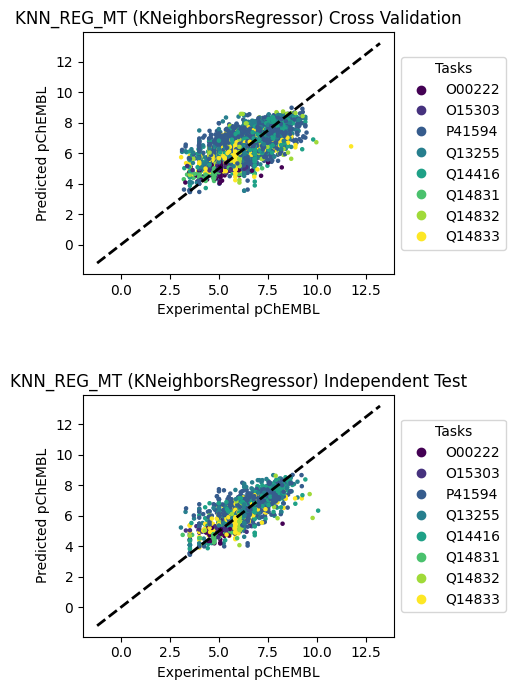

In [10]:
import math
from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np

property_name = "pChEMBL"

my_cmap = ["#12517B", "#88002A"]

plt.figure(figsize=(5, 7))
cate = ["qspr/models/KNN_REG_MT/KNN_REG_MT.cv.tsv", "qspr/models/KNN_REG_MT/KNN_REG_MT.ind.tsv"]
cate_names = ["cv", "ind"]
ret_axes = []
summary = {"ModelName": [], "R2": [], "RMSE": [], "Set": []}


for m, mymodel in enumerate([model]):
    min_val = 0
    max_val = 10
    for j, cate_name in enumerate(['Cross Validation', 'Independent Test']):
        ax = plt.subplot(2, len([model]), m + j + 1)
        ret_axes.append(ax)
        #todo create subplot show can show both plots
        df = pd.read_table(cate[j])
        # column names containing original labels or predictions for the tasks
        label_names = [i for i in list(df.columns.values) if "imputed_Label" in i]  #df[f"{property_name}_imputed_Label"]
        labels = [i.replace("_imputed_Label", '') for i in label_names]
        pred_names = [i for i in list(df.columns.values) if "imputed_Prediction" in i] #df[f"{property_name}_imputed_Prediction"]

        # # create mask with True if original value, False where no value in original  dataset
        # #TODO currently does not work because do not have df with cv / ind, nee
        # array = df_that_does_not_exist_yet[labels].to_numpy()
        # mask = ~np.isnan(array)
        
        # turn ylabel and ypred into np array
        ylabel = df[label_names].to_numpy()
        c = np.zeros(ylabel.shape)
        for k in range(c.shape[1]):
            c[:, k] = k
        c.flatten()
        
        ylabel = ylabel.flatten()
        ypred = df[pred_names].to_numpy().flatten()
        # mask = mask.flatten()

        # # no markers for inputed values
        # area = np.full(mask.shape, 5)
        # area1 = np.ma.masked_where(mask, area)
        # scatter = plt.scatter(
        #     ylabel,
        #     ypred,
        #     s=area1,
        #     c=c)

        scatter = plt.scatter(
            ylabel,
            ypred,
            s=5,
            c=c)
        coef = metrics.r2_score(ylabel, ypred)
        rmse = metrics.mean_squared_error(
            ylabel, ypred,
            squared=False)
        summary["R2"].append(coef)
        summary["RMSE"].append(rmse)
        summary["Set"].append(cate_names[j])
        summary["ModelName"].append(model.name)

        plt.title(f'{model} {cate_name}')
        plt.xlabel(f"Experimental {property_name}")
        plt.ylabel(f"Predicted {property_name}")
        min_val_now = math.floor(
            min(np.concatenate((ylabel, ypred))))
        max_val_now = math.ceil(
            max(np.concatenate((ylabel, ypred))))
        if min_val_now < min_val:
            min_val = min_val_now
        if max_val_now > max_val:
            max_val = max_val_now
        pad = (max_val - min_val) * 0.1
        plt.plot(
            [min_val - pad, max_val + pad],
            [min_val - pad, max_val + pad],
            lw=2, linestyle='--', color='black')

        handles, _ = scatter.legend_elements()

        plt.legend(handles, labels, title="Tasks", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.5)

In [11]:
summary

{'ModelName': ['KNN_REG_MT', 'KNN_REG_MT'],
 'R2': [0.8209201089933391, 0.8315319235760192],
 'RMSE': [0.3575020643782096, 0.3490389580282648],
 'Set': ['cv', 'ind']}